In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from dataset.configuration_grounding import DatasetConfig, ImageProcessorConfig
from dataset.instruction_grounding_dataset import make_instruction_grounding_dataset
from dataset.image_processor import ImageProcessor
from transformers import AutoTokenizer

dataset_config = DatasetConfig()
tokenizer1 = AutoTokenizer.from_pretrained("/home/jihuawei2/projects/AceRead/pretrain_weights/xgen-mm-phi3-mini-Instruct/xgen")
tokenizer2 = AutoTokenizer.from_pretrained("/home/jihuawei2/projects/AceRead/pretrain_weights/xgen-mm-phi3-mini-Instruct/siglip-so400m-patch14-384")

image_processor_config = ImageProcessorConfig()
image_processor = ImageProcessor(image_processor_config)
instruction_grounding_dataset, num_samples = make_instruction_grounding_dataset(
    dataset_config=dataset_config,
    tokenizer1=tokenizer1,
    tokenizer2=tokenizer2,
    image_processor=image_processor,
)
print("num_samples:", num_samples)
print("anyres_grids:", instruction_grounding_dataset.dataloader.dataset.anyres_grids)
for batch in instruction_grounding_dataset.dataloader:
    print(batch.keys())
    position_distributions = batch['position_distributions']
    print(position_distributions[0].shape)
    vision_x = batch['vision_x']
    print("vision_x shape:", vision_x[0][0].shape)
    print("image files:", batch['image_files'][0])
    break


/home/jihuawei2/miniconda3/envs/main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.5 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


num_samples: 1500
anyres_grids: [[384, 384], [384, 768], [384, 1152], [384, 1536], [384, 1920], [384, 2304], [384, 2688], [384, 3072], [384, 3456], [768, 384], [768, 768], [768, 1152], [768, 1536], [1152, 384], [1152, 768], [1152, 1152], [1536, 384], [1536, 768], [1920, 384], [2304, 384], [2688, 384], [3072, 384], [3456, 384]]
dict_keys(['lang_x', 'labels', 'attention_mask', 'lang_y', 'image_size', 'image_patch_num', 'vision_x', 'image_files', 'position_distributions'])
torch.Size([6561])
vision_x shape: torch.Size([10, 3, 384, 384])
image files: ['/home/zjr2022/datasets/train/VizWiz_train_00006763.jpg']


In [13]:
tokenizer2.batch_decode(batch['lang_y']['input_ids'])

['what does this microwave say</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>']

In [20]:
batch['lang_y']

{'input_ids': tensor([[ 347,  534,  291, 8449,  593,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1]])}

In [19]:
tokenizer1.batch_decode(batch['lang_x'])

["<|system|> A chat between a curious user and an artificial intelligence assistant. The assistant gives concise answers to the user's questions.<|end|><|user|> <image>\nWhat does this microwave say?<|end|><|assistant|> 2:20<|end|>"]

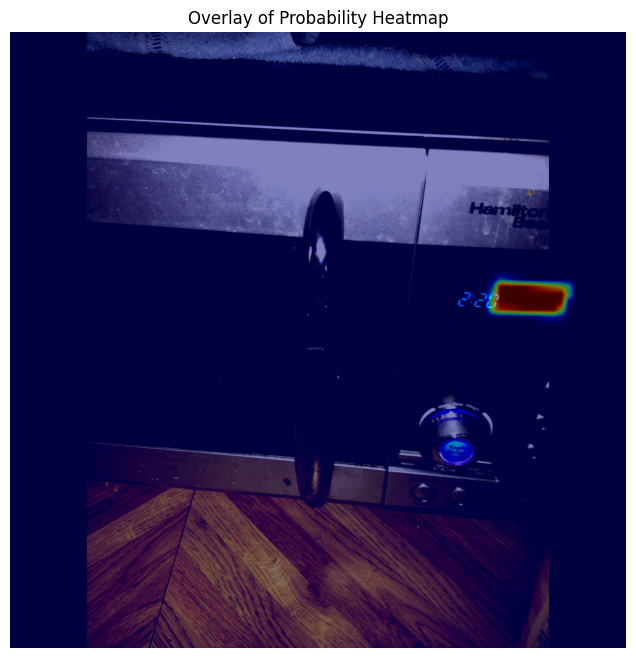

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


tensor = vision_x[0][0]
patches = tensor[1:]
row1 = torch.cat([patches[0], patches[1], patches[2]], dim=2)
row2 = torch.cat([patches[3], patches[4], patches[5]], dim=2)
row3 = torch.cat([patches[6], patches[7], patches[8]], dim=2)
reconstructed_image = torch.cat([row1, row2, row3], dim=1)  # 结果形状为 (3, 1152, 1152)
reconstructed_image_np = reconstructed_image.permute(1, 2, 0).numpy()
prob = position_distributions[0]

prob_patches = prob.reshape(9, 27, 27)
prob_patches = prob_patches.unsqueeze(1)
prob_heatmaps = F.interpolate(prob_patches, size=(384, 384), mode='bilinear', align_corners=False)
prob_heatmaps = prob_heatmaps.squeeze(1)

patch_size = 384
full_heatmap = np.zeros((patch_size * 3, patch_size * 3))
for i in range(9):
    row = i // 3  # 行号：0, 1, 2
    col = i % 3   # 列号：0, 1, 2
    start_y = row * patch_size
    start_x = col * patch_size
    full_heatmap[start_y:start_y+patch_size, start_x:start_x+patch_size] = prob_heatmaps[i].detach().cpu().numpy()

full_heatmap = (full_heatmap - full_heatmap.min()) / (full_heatmap.max() - full_heatmap.min())

plt.figure(figsize=(8,8))
plt.imshow(reconstructed_image_np)  
plt.imshow(full_heatmap, cmap='jet', alpha=0.5)  
plt.axis('off')
plt.title("Overlay of Probability Heatmap")
plt.show()

In [25]:
position_distributions

{0: tensor([0., 0., 0.,  ..., 0., 0., 0.])}

In [17]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
# )

# # We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# # model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
# #     "Qwen/Qwen2.5-VL-3B-Instruct",
# #     torch_dtype=torch.bfloat16,
# #     attn_implementation="flash_attention_2",
# #     device_map="auto",
# # )

# # default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
# inputs = inputs.to("cuda")

# # Inference: Generation of the output
# generated_ids = model.generate(**inputs, max_new_tokens=128)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text)


In [19]:
inputs['pixel_values'].shape

torch.Size([14308, 1176])

In [1]:
from PIL import Image
from transformers import Qwen2VLImageProcessor
import numpy as np
import matplotlib.pyplot as plt

processor = Qwen2VLImageProcessor.from_pretrained("/home/jihuawei2/projects/WinJob/pretrained_weight/Qwen2.5-VL-3B-Instruct")
img = Image.open("/home/zjr2022/datasets/train/VizWiz_train_00011948.jpg")

image_inputs = processor.preprocess(img)

image_grid_thw = image_inputs['image_grid_thw']
pixel_values = image_inputs['pixel_values']

channel = 3
grid_h = image_grid_thw[0][1] 
grid_w = image_grid_thw[0][2]  
patch_size = processor.patch_size
merge_size = processor.merge_size
resized_h = grid_h*patch_size
resized_w = grid_w*patch_size
temporal_patch_size = processor.temporal_patch_size

tokens_grid = pixel_values.reshape(1, grid_h//merge_size,\
                                      grid_w//merge_size, \
                                      merge_size, merge_size,\
                                      channel, temporal_patch_size,\
                                      patch_size, patch_size)

tokens_grid = tokens_grid.transpose(0, 6, 5, 1, 3, 7, 2, 4, 8)
tokens_grid = tokens_grid.reshape(temporal_patch_size, channel,\
                                  grid_h*patch_size,\
                                  grid_w*patch_size)
tokens_grid = tokens_grid[0]
tokens_grid = tokens_grid.transpose(1, 2, 0) 

tokens_grid = (tokens_grid - tokens_grid.min()) / (tokens_grid.max() - tokens_grid.min())

tokens_grid *= 255 
normalized_array = tokens_grid.astype(np.uint8)
image = Image.fromarray(normalized_array)
image.save('o1.png')

/home/jihuawei2/miniconda3/envs/main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
tokens_grid

array([[[0.94526356, 0.94526356, 0.94526356, ..., 0.13344897,
         0.05189683, 0.05189683],
        [0.9819679 , 0.9819679 , 0.9819679 , ..., 0.14738993,
         0.06355105, 0.06355105],
        [1.        , 1.        , 1.        , ..., 0.16589586,
         0.08645735, 0.08645735]],

       [[0.94526356, 0.94526356, 0.94526356, ..., 0.07784524,
         0.0667245 , 0.08155217],
        [0.9819679 , 0.9819679 , 0.9819679 , ..., 0.09022706,
         0.07879448, 0.09403791],
        [1.        , 1.        , 1.        , ..., 0.11173324,
         0.10090073, 0.11534409]],

       [[0.94526356, 0.94526356, 0.94526356, ..., 0.1149144 ,
         0.04818993, 0.088966  ],
        [0.9819679 , 0.9819679 , 0.9819679 , ..., 0.12833565,
         0.0597402 , 0.10165964],
        [1.        , 1.        , 1.        , ..., 0.14784165,
         0.08284653, 0.12256577]],

       ...,

       [[0.7450901 , 0.6931933 , 0.7228486 , ..., 0.79328   ,
         0.8044008 , 0.8118146 ],
        [0.7571273 , 

In [21]:
grid_h

116

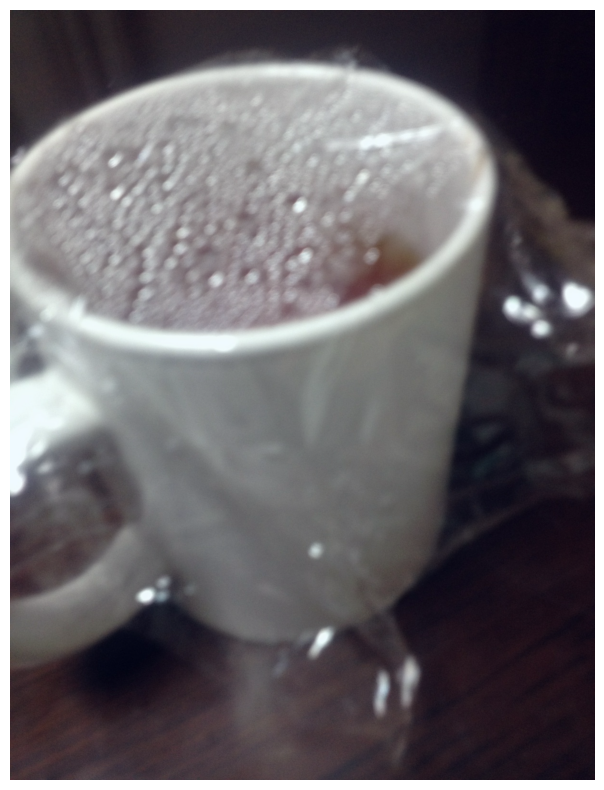

In [ ]:
tokens = image_inputs['pixel_values']  # (10208, 1176)
grid_h = 116  # 垂直方向上 patch 的数量
grid_w = 88   # 水平方向上 patch 的数量
patch_size = 14
channel = 3
temporal_patch_size = 2  # 两帧

tokens_grid = tokens.reshape(1, 58, 44, 2, 2, 3, 2, 14, 14)
tokens_grid = tokens_grid.transpose(0, 6, 5, 1, 3, 7, 2, 4, 8)
tokens_grid = tokens_grid.reshape(2, 3, 1624, 1232)
tokens_grid = tokens_grid[0]

tokens_grid = tokens_grid.transpose(1, 2, 0) 

tokens_grid = (tokens_grid - tokens_grid.min()) / (tokens_grid.max() - tokens_grid.min())

plt.figure(figsize=(10, 10))
plt.imshow(tokens_grid)
plt.axis('off') 
plt.show()


In [2]:
a = {"a":1, "b":2}
a.pop("a")

1

In [3]:
a

{'b': 2}